# Question 1: Image Classification

In [29]:
import torch
import numpy as np

In [69]:
# 1. Check If GPU is available
device = torch.cuda.is_available()

In [68]:
# 2. Load data

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


# ndarray -> tensor, Normalization & Standardization。
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# load trian and text data
train_data = CIFAR10('data', train=True, download=False, transform=transform)
test_data = CIFAR10('data', train=False, download=False, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

# 20% of training set to use as validation
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=16, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, num_workers=0)

# CIFAR10 classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/home/tyler/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


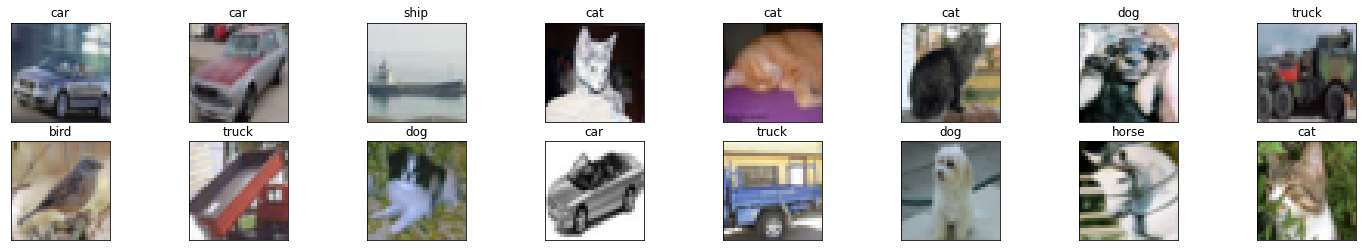

In [40]:
# 3. Check samples in train_loader

import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

    
# get sample images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# *images = > (channel,h,w) need convert to (h,w,channel) to show image.

# convert images to numpy for display
images = images.numpy()

# show 16 images, and title is class name
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    # unnormalize
    img = images[idx] / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))  # *
    ax.set_title(classes[labels[idx]])

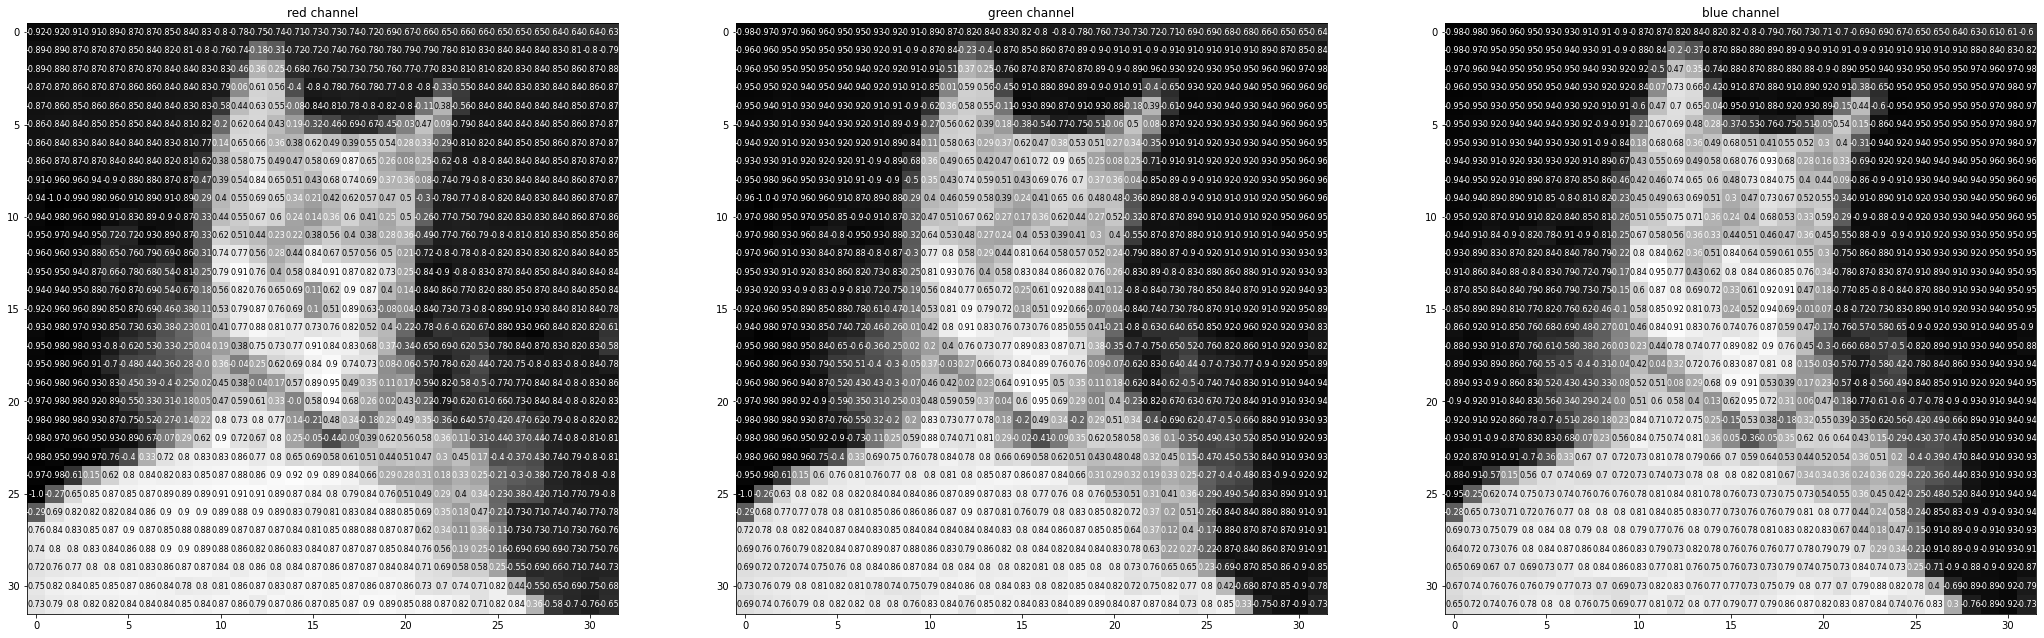

In [41]:
# More detiles about one image: the gray-scale for each channel

rgb_img = np.squeeze(images[3])    # cat
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [65]:
# 4. Construct a CNN model

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.conv3 = nn.Conv2d(32,64,3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # add sequence of convolutional, relu and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

    
model = Net()
print(model)

# load to GPU
if torch.cuda.is_available():
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [66]:
# 5. Define a loss and optimize function

import torch.optim as optim
# loss
criterion = nn.CrossEntropyLoss()
# SGD optimize with learning rate 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [70]:
# 6. Train

epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train model
    model.train()
    for data, target in train_loader:
        if device:
            data, target = data.cuda(), target.cuda()    # move tensors to GPU if CUDA is available
        optimizer.zero_grad()                            # clear the gradients of all optimized variables
        # forward
        output = model(data)
        loss = criterion(output, target)
        # backward
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)    # update training loss
        
    # evaluate model
    model.eval()
    for data, target in valid_loader:
        if device:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # mean loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # save model if valid loss decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	 Training Loss: 2.300951 	 Validation Loss: 2.298706
Validation loss decreased (inf --> 2.298706).  Saving model ...
Epoch: 2 	 Training Loss: 2.269848 	 Validation Loss: 2.208429
Validation loss decreased (2.298706 --> 2.208429).  Saving model ...
Epoch: 3 	 Training Loss: 2.182764 	 Validation Loss: 2.149406
Validation loss decreased (2.208429 --> 2.149406).  Saving model ...
Epoch: 4 	 Training Loss: 2.146244 	 Validation Loss: 2.116428
Validation loss decreased (2.149406 --> 2.116428).  Saving model ...
Epoch: 5 	 Training Loss: 2.121677 	 Validation Loss: 2.103298
Validation loss decreased (2.116428 --> 2.103298).  Saving model ...
Epoch: 6 	 Training Loss: 2.101862 	 Validation Loss: 2.076372
Validation loss decreased (2.103298 --> 2.076372).  Saving model ...
Epoch: 7 	 Training Loss: 2.081904 	 Validation Loss: 2.052828
Validation loss decreased (2.076372 --> 2.052828).  Saving model ...
Epoch: 8 	 Training Loss: 2.062920 	 Validation Loss: 2.036303
Validation loss de

In [71]:
# 7. load pt file (model)
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [73]:
# 8. track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    if device:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target) 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    
    # compare prediction to groud truth
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not device else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class, batch size is 16
    for i in range(16):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.830012

Test Accuracy of plane: 75% (757/1000)
Test Accuracy of   car: 80% (808/1000)
Test Accuracy of  bird: 46% (468/1000)
Test Accuracy of   cat: 50% (504/1000)
Test Accuracy of  deer: 57% (578/1000)
Test Accuracy of   dog: 53% (536/1000)
Test Accuracy of  frog: 59% (595/1000)
Test Accuracy of horse: 70% (701/1000)
Test Accuracy of  ship: 72% (725/1000)
Test Accuracy of truck: 66% (665/1000)

Test Accuracy (Overall): 63% (6337/10000)


/home/tyler/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


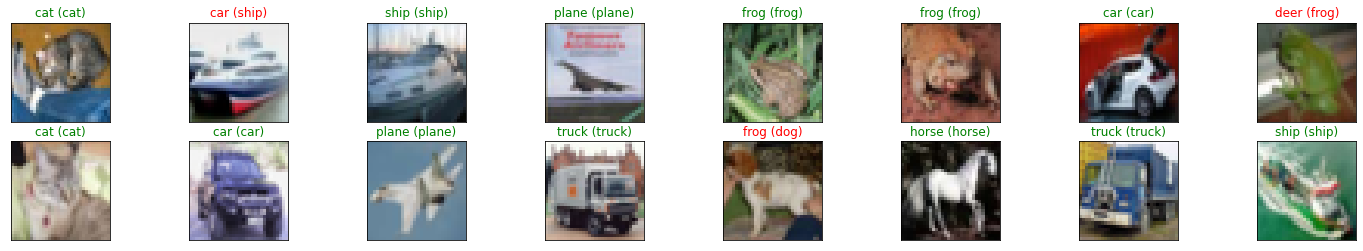

In [74]:
# 9. Show one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if device:
    images = images.cuda()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not device else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch with prediction and ground truth
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))

# Question 2: Image segmentation

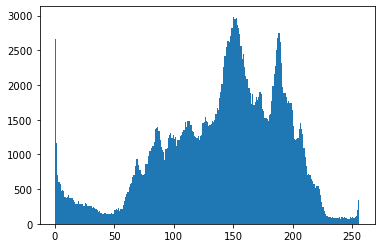

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread('city.jpg',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

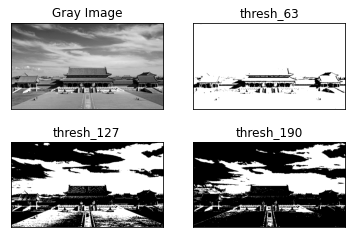

In [5]:
# cv2.threshold(src, thresh, maxval, type[, dst]) → retval, dst

ret,thresh1=cv2.threshold(image,47,255,cv2.THRESH_BINARY)
ret,thresh2=cv2.threshold(image,150,255,cv2.THRESH_BINARY)
ret,thresh3=cv2.threshold(image,170,255,cv2.THRESH_BINARY)

titles = ['Gray Image','thresh_63','thresh_127','thresh_190']
images = [image, thresh1, thresh2, thresh3]

for i in range(4):
   plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
   plt.title(titles[i])
   plt.xticks([]),plt.yticks([])
plt.show()



125
101
176


/home/tyler/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/tyler/anaconda3/envs/pytorch_env/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


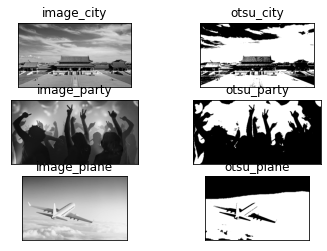

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def otsu(gray):
    # Total number of pixels
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weigth = 1.0/pixel_number
    
    # Calculate histogram
    his, bins = np.histogram(gray, np.arange(0,257))    # bins need to be 257 to cover the max pixel vaule 255
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)
    for t in bins[1:-1]:
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        
        # Weight Background
        wB = pcb * mean_weigth
        
        # Weight Foreground
        wF = pcf * mean_weigth
        
        # Mean Background
        mB = np.sum(intensity_arr[:t]*his[:t]) / float(pcb)
        
        # Mean Foreground
        mF = np.sum(intensity_arr[t:]*his[t:]) / float(pcf)
        
        # Calculate Between Class Variance
        value = wB * wF * (mB - mF) ** 2
        
        # Check if new maximum found
        if value > final_value:
            final_thresh = t
            final_value = value
            
    final_img = gray.copy()
    print(final_thresh)
    final_img[gray > final_thresh] = 255
    final_img[gray < final_thresh] = 0
    return final_img


image_city = cv2.imread("city.jpg",0)
image_party = cv2.imread("party.jpg",0)
image_plane = cv2.imread("plane.jpg",0)
otsu_city = otsu(image_city)
otsu_party = otsu(image_party)
otsu_plane = otsu(image_plane)

titles = ['image_city','otsu_city','image_party','otsu_party', 'image_plane', 'otsu_plane']
images = [image_city, otsu_city, image_party, otsu_party, image_plane, otsu_plane]

for i in range(6):
   plt.subplot(3,2,i+1),plt.imshow(images[i],'gray')
   plt.title(titles[i])
   plt.xticks([]),plt.yticks([])
plt.show()

# cv2.imshow('img', image)
# cv2.imshow('otsu', otsu_img)
# cv2.waitKey(0)
# cv2.destroyAllWindow()